# Bivariate analysis


The objective of this notebook is to analyze each variable vs. the target to understand patterns, associations, and potential causal relationships between the variables.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, ks_2samp
import category_encoders as ce
import os
import warnings
from IPython.display import Image

warnings.filterwarnings("ignore")

base_directory = 'images/images_bivar_analysis'
os.makedirs(base_directory, exist_ok=True)

In [3]:
data = pd.read_parquet('../data/silver/df_fraud_univar.parquet', engine= 'fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud,1,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000


## step & day_of_month vs. isFraud

I use the Mann-Whitney U Test because the variable 'step' doesn't follow a normal distribution. This test is robust in front of unbalanced data.

In [ ]:
group1 = data[data['isFraud'] == 'fraud']['step']
group2 = data[data['isFraud'] == 'no_fraud']['step']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

- p-value = 0 so there is a significative statistical difference of 'step' between the two catories of 'isFraud'. The variable 'step' behaves differently in each group.

- Mann-Whitney U Statistic: 34829829709.5. The range between both groups is very huge. 

But as we saw in the univariate analysis our independent variable is VERY unbalanced and this can affect statistical results with any test:

isFraud
- no_fraud    6354407
- fraud          8213

isFraud
- no_fraud    99.871%
- fraud        0.129%

Making more than one test is always useful when having very unbalanced data. The Kolmogorov-Smirnov Test can be useful when we can't assume normality in unbalanced dataset. 

In [ ]:
ks_stat, ks_p_value = ks_2samp(group1, group2)

print(f"KS Statistic: {ks_stat}")
print(f"P-Value: {ks_p_value}")

- KS Statistic = 0.38 means that there is a difference of the 38% in some point of the CDF (Cumulative Distribution Function) = clear discrepancy between distributions

- p-value = 0, same conclusion as before

In [ ]:
filename = 'freq_of_step_in_total_transactions.png'
plot_filename = os.path.join(base_directory, filename)

if not os.path.isfile(plot_filename):

    total_value_counts = data['step'].value_counts().sort_index()
    fraud_value_counts = data[data['isFraud'] == 'fraud']['step'].value_counts().sort_index()
    non_fraud_value_counts = data[data['isFraud'] == 'no_fraud']['step'].value_counts().sort_index()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20), sharex=True)

    titles = [
        "Frequency of Steps in Total Transactions", 
        "Frequency of Steps in Fraudulent Transactions", 
        "Frequency of Steps in Non-Fraudulent Transactions"
    ]
    colors = ['#00008B', '#8B0000', '#006400']
    counts_list = [total_value_counts, fraud_value_counts, non_fraud_value_counts]

    for ax, counts, title, color in zip(axes, counts_list, titles, colors):
        ax.plot(counts.index, counts, marker='o', color=color, linestyle='-', markersize=6)
        ax.set_title(title)
        ax.set_xlabel("Step")
        ax.set_ylabel("Frequency")
        ax.grid(True, which='both', linestyle='--', linewidth=0.7)
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 24)) 
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 1), minor=True)  
        ax.tick_params(axis='x', which='minor', length=3, color='grey')

    plt.tight_layout()
    plt.savefig(plot_filename)  
    plt.close(fig)  

Image(filename=plot_filename)

In [ ]:
#TODO - fix x axis and x labels (de 24 en 24)

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

Non-fraudulent transactions vary over time, fraudulent transactions remain constant.


Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). 
- The first step range makes sense since people get their salaries at the beginning of the month. 
- The second step range, as I said in the univariate analysis notebook doesn't make sense to me. In this case it would be helpful to know, for example, which month of the year it is to understand if there is any special event in the middle of the month that made people use more transactions.
- There is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a bank holiday so people would be on holidays? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 
- There is also a step with very high frequency between the steps 193 and 217.
- Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

---

What is happening in the very frequent step? How is the relationship between that step and fraud?

In [ ]:
contingency_table = pd.crosstab(data['step'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100

contingency_table.loc[(contingency_table.index > 193) & (contingency_table.index < 220)]

Observations:

There are far more fraudulent transactions on the step 212. 212 steps = 8 days + 20h.
- Why so many people are commiting fraud that day? Why at that time? Was it a coincidence? 
- Was it Black Friday or maybe another special day where a website makes offers?
Time to ask what could have happened here from a business perspective and check the characteristics of those transactions.


The are also other picks on the fraudulent transactions that could be analysed along the gaps of days between them even though the amount of fraud transactions are very constant over time. 


----

Are night transactions more likely to be fraudulent? 

In [ ]:
time_data = data[['step', 'day_of_month', 'isFraud']].copy()
time_data['hour_of_day'] = data['step'] % 24
time_data

In [ ]:
count_hours = time_data.groupby(['hour_of_day']).agg(
    count_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'fraud').sum()),
    count_no_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'no_fraud').sum())
    
).reset_index()

count_hours    

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=count_hours, x='hour_of_day', y='count_fraud', marker='o')
plt.xlabel('Step')
plt.ylabel('Count of Fraud')
plt.title('Average of Fraud over Time Steps')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=count_hours, x='hour_of_day', y='count_no_fraud', marker='o')
plt.xlabel('Step')
plt.ylabel('Count of Fraud')
plt.title('Average of Fraud over Time Steps')
plt.grid()
plt.show()

Observations: 

The fraudulent transactions stay constant, the non-fraudulent transactions go down during the night.

---
Let's check the distribution of the column "day_of_the_month"

In [ ]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100
contingency_table

In [ ]:
contingency_table = time_data.groupby(['day_of_month', 'isFraud'], observed=True).size().unstack(fill_value=0)
# Calcular proporciones
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas
plt.figure(figsize=(12, 6))

# Trazar las barras apiladas con proporciones
proportions.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], ax=plt.gca())

# Configuración del gráfico
plt.title('Proportions of Fraud and No Fraud by Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()

plt.show()

Observations:

- The last day of the month has only fraudulent transactions. Curious, right? I would need more info about the context but it looks like it's a coincidence.
- In the same days where non fraudulent transactions (remember we had the hypothesis that it would may be )
Besides that I don't see any clear pattern.

## type vs. isFraud

In [ ]:
contingency_table = pd.crosstab(data['type'], data['isFraud'])
contingency_table

Observations:

The only types that have fraudulent transactions are CASH_OUT and TRANSFER and as we saw in the univariate analysis they are substantially less common

In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Observations:

- Chi-Square Statistic: 317,577.50. Big discrepancy between frequencies
- p-value: 0. Very likely that the observed asociation is random.

There are very low frequencies on the contingency table so I will apply the Monte Carlo aproximation on the Chi-square test


In [ ]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])

# Calcular el estadístico chi-cuadrado y el valor p observado
chi2_observed, _, _, _ = chi2_contingency(contingency_table)

# Función para simular una tabla de contingencia bajo la hipótesis nula
def simulate_contingency_table(observed_table):
    # Total número de observaciones
    total = observed_table.sum().sum()
    # Proporciones marginales
    row_totals = observed_table.sum(axis=1)
    col_totals = observed_table.sum(axis=0)
    
    # Generar la tabla simulada
    expected_frequencies = np.outer(row_totals, col_totals) / total
    simulated_table = np.random.multinomial(total, expected_frequencies.flatten()/total).reshape(observed_table.shape)
    
    return pd.DataFrame(simulated_table, index=observed_table.index, columns=observed_table.columns)

# Número de simulaciones
num_simulations = 10000
chi2_simulated = []

# Realizar las simulaciones
for _ in range(num_simulations):
    simulated_table = simulate_contingency_table(contingency_table)
    chi2_sim, _, _, _ = chi2_contingency(simulated_table)
    chi2_simulated.append(chi2_sim)

# Convertir a un array numpy para el cálculo
chi2_simulated = np.array(chi2_simulated)

# Calcular el valor p
p_value = np.mean(chi2_simulated >= chi2_observed)

# Imprimir los resultados
print(f"Chi-Square Statistic observed: {chi2_observed}")
print(f"P-Value (Simulated): {p_value}")

Observations: 

I reject hypothesis 0. 


In [ ]:
sns.countplot(x='type', hue='isFraud', data=data, palette = 'pastel')

plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count Plot of Type by Fraud Status')
plt.grid()
plt.show()

## amount vs. isFraud

In [ ]:
data

In [ ]:
contingency_table = pd.crosstab(data['amount_range'], data['isFraud'])
contingency_table

In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

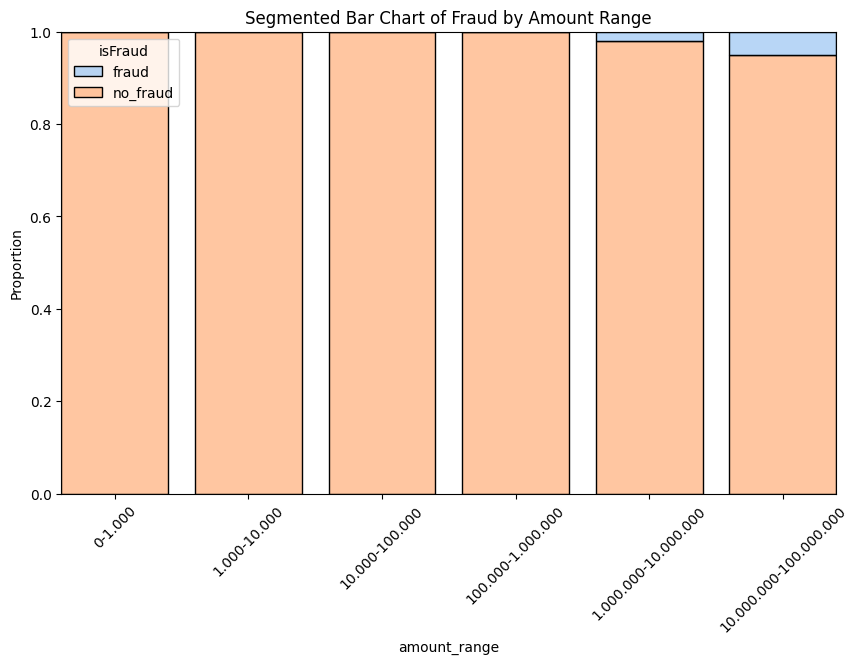

In [4]:
plt.figure(figsize=(10, 6))
segmented_bar = sns.histplot(
    data=data,
    x="amount_range", 
    hue="isFraud", 
    multiple="fill", 
    shrink=0.8,
    palette = 'pastel'
    
)
plt.xticks(rotation=45)
segmented_bar.set(ylabel="Proportion")
plt.title('Segmented Bar Chart of Fraud by Amount Range')
plt.show()

In [ ]:
data.query('amount == 0')

Observations:

Withrawals with amount = 0 are fraudulent, none of them is repeated and they have been used to try to withdraw money. We could analyze the origin and destination users and see their behaviour. One example could be using the postal code, the IP data, the account age, etc. to find hidden patterns.

/tmp/ipykernel_20906/426625421.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='isFraud', y='amount', data=data, palette='pastel')


Stats 0: [127091.328125      0.      ]
Stats 1: [1517771.5 3595911.5]
Stats 2: [0. 0.]
Stats 3: [3595911.5 3595911.5]
Stats 4: [441423.4375 441423.4375]
Stats 5: [10000000.   10000000.    5460003.    5460003.    3964130.    3964130.
  4022667.5   4022667.5   6188515.    6188515.   10000000.   10000000.
  3832058.25  3832058.25  5021186.5   5021186.5  10000000.   10000000.
  9887819.    9887819.    6648390.    6648390.    3606943.25  3606943.25
  9465989.    9465989.    5979556.    5979556.    7567170.5   7567170.5
  7937954.    7937954.    6188772.5   6188772.5   5032484.5   5032484.5
  5188875.5   5188875.5   4919642.5   4919642.5   7335355.5   7335355.5
  9977761.    9977761.    5489302.    5489302.    7484125.    7484125.
  3640271.25  3640271.25  4243468.    4243468.    6501303.    6501303.
  7108914.    7108914.    3904257.5   3904257.5   3857176.75  3857176.75
  3760068.    3760068.    7169130.    7169130.    4631432.    4631432.
  5800988.    5800988.    7728992.5   7728992.5   

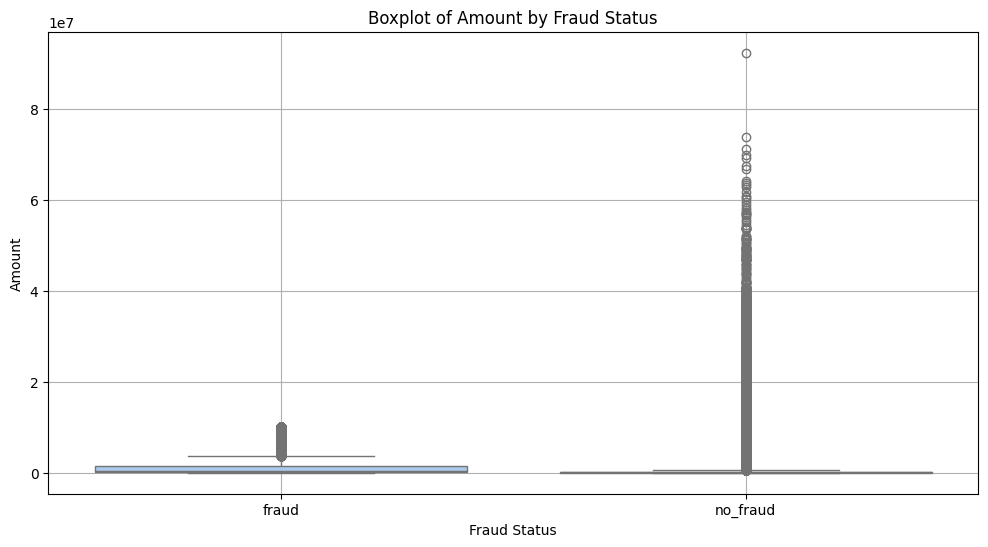

FileNotFoundError: [Errno 2] No such file or directory: 'images/images_bivar_analysis/amount_boxplot.png'

In [8]:
filename = 'amount_boxplot.png'
plot_filename = os.path.join(base_directory, filename)
    
if not os.path.isfile(plot_filename):
    plt.figure(figsize=(12, 6))
    boxplot = sns.boxplot(x='isFraud', y='amount', data=data, palette='pastel')

    def get_boxplot_stats(boxplot):
        stats = []
        for line in boxplot.get_lines():
            stats.append(line.get_ydata())
        return stats

    boxplot_stats = get_boxplot_stats(boxplot)

    for i, stat in enumerate(boxplot_stats):
        print(f'Stats {i}: {stat}')

    plt.title('Boxplot of Amount by Fraud Status')
    plt.xlabel('Fraud Status')
    plt.ylabel('Amount')
    plt.grid(True)
    plt.show()


Image(filename=plot_filename)


In [ ]:
small_amounts = data.query('amount < 40000')
small_amounts

In [ ]:
%store small_amounts

In [ ]:
small_amounts['isFraud'].value_counts()

In [ ]:
small_amounts['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

Observations:

The percentage of fraudulent transactions in small transactions is 0.033%, the percentage of fraud in the full dataset is 0.129%. 

In [ ]:
more_4k_amounts = data.query('400000 < amount')

In [ ]:
%store more_4k_amounts

In [ ]:
more_4k_amounts['isFraud'].value_counts()

In [ ]:
more_4k_amounts['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

Observations:

No visible relationship, let's dive deeper into bigger accounts

In [ ]:
is_cached = False
try:
    %store -r repeated_amounts
    is_cached = True
except NameError:
    is_cached = False

if is_cached:
    print("The DataFrame is already stored in cache")
else:
    print("DataFrame not found. Calculating...")

    repeated_rows = data[data.duplicated('amount', keep=False) & (data['amount'] != 0)]

    repeated_amounts = (repeated_rows.groupby('amount')
                    .agg(count_is_not_Fraud=('isFraud', lambda x: (x == 'no_fraud').sum()),
                            count_isFraud=('isFraud', lambda x: (x == 'fraud').sum()),
                            percentage_is_not_Fraud=('isFraud', lambda x: round((x == 'no_fraud').mean() * 100, 2)),
                            percentage_isFraud=('isFraud', lambda x: round((x == 'fraud').mean() * 100, 2)))
                    .reset_index())

    %store repeated_amounts

repeated_amounts

In [ ]:
repeated_amounts[(repeated_amounts['amount'] > 60) & (repeated_amounts['amount'] < 80)]

In [ ]:
data.query('amount == 38.439999')

In [ ]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='isFraud', y='amount', data=data)
plt.title('Violin Plot of Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [ ]:
is_cached = False

try:
    %store -r correlation
    if 'integer_amounts' in locals():
        is_cached = True
except (NameError, KeyError):
    is_cached = False

if is_cached:
    print("The integer amounts var is stored in cache")
else:
    print("integer_amounts not found. Calculating...")
    integer_rows = data[data['amount'] == data['amount'].astype(int)]

    integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({
        'count': x.shape[0],
        'percentage_isFraud_0': (x['isFraud'] == 0).mean() * 100,
        'percentage_isFraud_1': (x['isFraud'] == 1).mean() * 100
    })).reset_index()
    
    %store integer_amounts
    
integer_amounts

## nameOrig vs. isFraud

From the univariate analysis we found that there were many transactions with the same amount. Let's check them

## oldbalanceOrig vs. isFraud

## newbalanceOrig vs. isFraud

---

### Correlation

In [ ]:
numerical_cols = data.select_dtypes(include=['float32', 'int16']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols


In [ ]:
is_cached = False

try:
    %store -r correlation
    if 'correlation' in locals():
        is_cached = True
except (NameError, KeyError):
    is_cached = False

if is_cached:
    print("The correlation matrix is stored in cache")
else:
    print("Correlation matrix not found. Calculating...")
    
    encoder = ce.TargetEncoder(cols=categorical_cols)
    
    target_col = numerical_cols[0]
    
    df_encoded = encoder.fit_transform(data, data[target_col])
    correlation = df_encoded.corr()

    %store correlation


In [ ]:
correlation

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of the correlation matrix')
plt.show()

In [ ]:

threshold = 0.9

high_correlation_pairs = [(col1, col2) for col1 in correlation.columns for col2 in correlation.columns 
                          if col1 != col2 and abs(correlation.loc[col1, col2]) > threshold]

variables_to_remove = set()
for col1, col2 in high_correlation_pairs:
    if col1 not in variables_to_remove and col2 not in variables_to_remove:
        variables_to_remove.add(col2)

print(f"Variables to remove due to high correlation: {variables_to_remove}")

reduced_df = df_encoded.drop(columns=variables_to_remove)

reduced_correlation = reduced_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of the Reduced Correlation Matrix')
plt.show()

In [ ]:
reduced_df.to_parquet('../data/gold/df_final.parquet', engine= 'fastparquet')